# **Part 1**

## Serial Edition

In [ ]:
import cv2
import numpy as np
import time

!wget -O flower.jpg "https://media.geeksforgeeks.org/wp-content/uploads/20211220204344/pexelsylanitekoppens23431701.jpg"

image = cv2.imread("flower.jpg", cv2.IMREAD_GRAYSCALE)

sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)

sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]], dtype=np.float32)

# Pad the image to handle borders
padded_image = np.pad(image, pad_width=1, mode='constant', constant_values=0)

grad_x = np.zeros_like(image, dtype=np.float32)
grad_y = np.zeros_like(image, dtype=np.float32)

start_time_serial = time.time()

for i in range(1, padded_image.shape[0] - 1):
    for j in range(1, padded_image.shape[1] - 1):
        region = padded_image[i-1:i+2, j-1:j+2]
        grad_x[i-1, j-1] = np.sum(region * sobel_x)
        grad_y[i-1, j-1] = np.sum(region * sobel_y)

# Compute the gradient magnitude
gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

# Normalize the output to 8-bit range for visualization
gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

end_time_serial  = time.time()

serial_runtime = end_time_serial - start_time_serial

print(f"Runtime for serial Sobel filter: {serial_runtime:.4f} seconds")

# output_path = 'serial_sobel_output.jpg'
# cv2.imwrite(output_path, gradient_magnitude)
# print(f"Serial Sobel output saved to {output_path}")

--2025-01-11 11:58:04--  https://media.geeksforgeeks.org/wp-content/uploads/20211220204344/pexelsylanitekoppens23431701.jpg
Resolving media.geeksforgeeks.org (media.geeksforgeeks.org)... 3.169.55.117, 3.169.55.12, 3.169.55.26, ...
Connecting to media.geeksforgeeks.org (media.geeksforgeeks.org)|3.169.55.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90599 (88K) [image/jpeg]
Saving to: ‘flower.jpg’

flower.jpg          100%[===================>]  88.48K  --.-KB/s    in 0.01s   

2025-01-11 11:58:05 (8.63 MB/s) - ‘flower.jpg’ saved [90599/90599]

Runtime for serial Sobel filter: 4.5194 seconds


## Parallel Edition

Processes: 2, Runtime: 3.4437 seconds, Speedup: 1.31, Efficiency: 0.66
Processes: 4, Runtime: 3.4466 seconds, Speedup: 1.31, Efficiency: 0.33
Processes: 8, Runtime: 5.1484 seconds, Speedup: 0.88, Efficiency: 0.11
Processes: 16, Runtime: 3.8266 seconds, Speedup: 1.18, Efficiency: 0.07


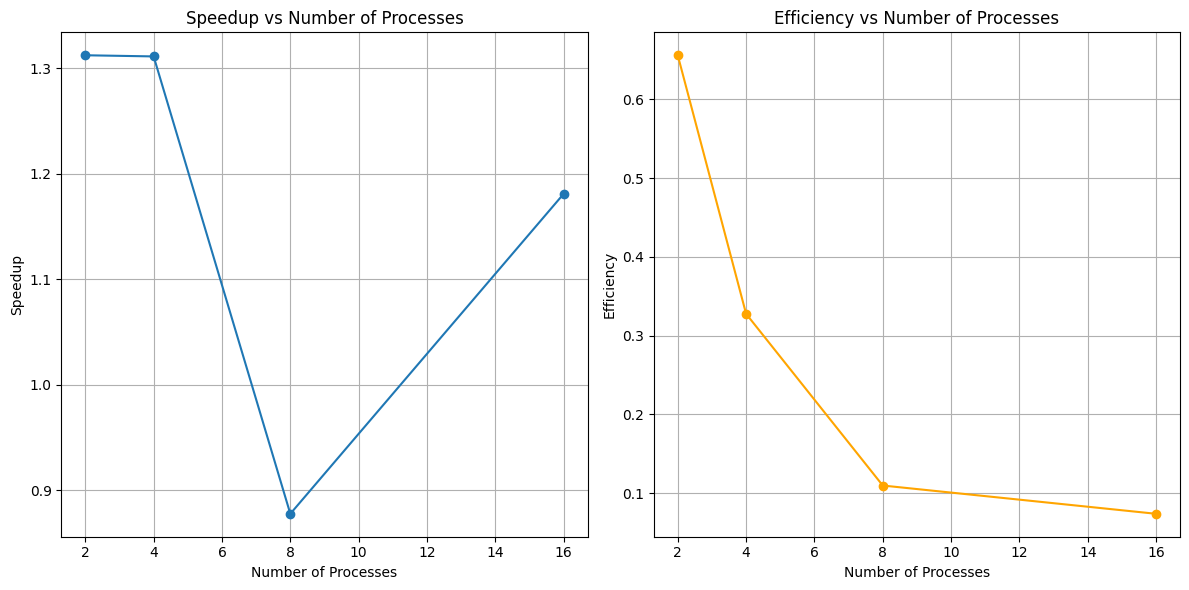

In [ ]:
import cv2
import numpy as np
import time
from multiprocessing import Pool
import matplotlib.pyplot as plt

def process_chunk(chunk_data):
    chunk, sobel_x, sobel_y = chunk_data
    padded_chunk = np.pad(chunk, pad_width=1, mode='constant', constant_values=0)
    grad_x = np.zeros_like(chunk, dtype=np.float32)
    grad_y = np.zeros_like(chunk, dtype=np.float32)

    for i in range(1, padded_chunk.shape[0] - 1):
        for j in range(1, padded_chunk.shape[1] - 1):
            region = padded_chunk[i-1:i+2, j-1:j+2]
            grad_x[i-1, j-1] = np.sum(region * sobel_x)
            grad_y[i-1, j-1] = np.sum(region * sobel_y)

    return grad_x, grad_y

def process_image_with_multiprocessing(image, num_processes):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)

    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32)

    # Split the image into chunks
    chunk_height = image.shape[0] // num_processes
    chunks = []

    for i in range(num_processes):
        start_row = max(0, i * chunk_height - 1)  # Overlap with the previous chunk
        end_row = min(image.shape[0], (i + 1) * chunk_height + 1)  # Overlap with the next chunk
        chunk = image[start_row:end_row]
        chunks.append((chunk, sobel_x, sobel_y))

    start_time = time.time()
    with Pool(processes=num_processes) as pool:
        results = pool.map(process_chunk, chunks)
    end_time = time.time()

    grad_x_chunks = []
    grad_y_chunks = []

    for i, (grad_x_chunk, grad_y_chunk) in enumerate(results):
        if i == 0:
            grad_x_chunks.append(grad_x_chunk[:-1])
            grad_y_chunks.append(grad_y_chunk[:-1])
        elif i == num_processes - 1:
            grad_x_chunks.append(grad_x_chunk[1:])
            grad_y_chunks.append(grad_y_chunk[1:])
        else:
            grad_x_chunks.append(grad_x_chunk[1:-1])
            grad_y_chunks.append(grad_y_chunk[1:-1])

    grad_x = np.vstack(grad_x_chunks)
    grad_y = np.vstack(grad_y_chunks)

    # Compute the gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return end_time - start_time, gradient_magnitude

if __name__ == "__main__":
    image = cv2.imread("flower.jpg", cv2.IMREAD_GRAYSCALE)

    num_processes_list = [2, 4, 8, 16]
    speedups = []
    efficiencies = []

    for num_processes in num_processes_list:
        runtime, gradient_magnitude = process_image_with_multiprocessing(image, num_processes)
        speedup = serial_runtime / runtime
        efficiency = speedup / num_processes

        speedups.append(speedup)
        efficiencies.append(efficiency)

        # output_filename = f"output_{num_processes}_processes.jpg"
        # cv2.imwrite(output_filename, gradient_magnitude)

        print(f"Processes: {num_processes}, Runtime: {runtime:.4f} seconds, Speedup: {speedup:.2f}, Efficiency: {efficiency:.2f}")

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(num_processes_list, speedups, marker='o')
    plt.title('Speedup vs Number of Processes')
    plt.xlabel('Number of Processes')
    plt.ylabel('Speedup')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(num_processes_list, efficiencies, marker='o', color='orange')
    plt.title('Efficiency vs Number of Processes')
    plt.xlabel('Number of Processes')
    plt.ylabel('Efficiency')
    plt.grid()

    plt.tight_layout()
    plt.show()

# **Part 2**

In [ ]:
!apt-get update
!apt-get install -y libopencv-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,199 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,588 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [ ]:
%%writefile  part2.cu

#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>
#include <iostream>
#include <cmath>

#define BLOCK_WIDTH 16

__global__ void sobel_filter_rowwise_unrolled(const unsigned char* input, unsigned char* output, int width, int height) {
    int row = blockIdx.x * blockDim.x + threadIdx.x; // Each thread processes a row
    if (row >= height) return;

    const int sobel_x[] = {-1, 0, 1, -2, 0, 2, -1, 0, 1};
    const int sobel_y[] = {-1, -2, -1, 0, 0, 0, 1, 2, 1};

    for (int col = 0; col < width; ++col) {
        float grad_x = 0.0f;
        float grad_y = 0.0f;

        int idx = 0;
        for (int i = -1; i <= 1; ++i) {
            for (int j = -1; j <= 1; ++j, ++idx) {
                int r = max(0, min(height - 1, row + i));
                int c = max(0, min(width - 1, col + j));
                float pixel_value = static_cast<float>(input[r * width + c]);
                grad_x += pixel_value * sobel_x[idx];
                grad_y += pixel_value * sobel_y[idx];
            }
        }

        output[row * width + col] = static_cast<unsigned char>(sqrtf(grad_x * grad_x + grad_y * grad_y));
    }
}

int main() {
    cv::Mat input = cv::imread("flower.jpg", cv::IMREAD_GRAYSCALE);

    int width = input.cols;
    int height = input.rows;

    cv::Mat output(height, width, CV_8UC1);

    unsigned char *d_input, *d_output;
    cudaMalloc(&d_input, width * height * sizeof(unsigned char));
    cudaMalloc(&d_output, width * height * sizeof(unsigned char));

    cudaMemcpy(d_input, input.ptr(), width * height * sizeof(unsigned char), cudaMemcpyHostToDevice);

    // Define grid and block dimensions
    int num_threads_per_block = BLOCK_WIDTH;
    int num_blocks = (height + num_threads_per_block - 1) / num_threads_per_block;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    sobel_filter_rowwise_unrolled<<<num_blocks, num_threads_per_block>>>(d_input, d_output, width, height);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    cudaMemcpy(output.ptr(), d_output, width * height * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    cv::imwrite("output_cuda_unrolled.jpg", output);

    cudaFree(d_input);
    cudaFree(d_output);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    std::cout << "CUDA Sobel filter applied in " << milliseconds << " ms.\n";

    return 0;
}

Overwriting part2.cu


In [ ]:
!nvcc part2.cu -o part2 `pkg-config --cflags --libs opencv4` -diag-suppress=611
!./part2

CUDA Sobel filter applied in 0.59248 ms.


# **Part 3**

In [ ]:
%%writefile  part3.cu

#include <iostream>
#include <fstream>
#include <cmath>
#include <curand_kernel.h>

#define M_PI 3.14159265358979323846f

struct Vec3 {
    float x, y, z;

    __host__ __device__ Vec3() : x(0), y(0), z(0) {}
    __host__ __device__ Vec3(float x, float y, float z) : x(x), y(y), z(z) {}

    __host__ __device__ Vec3 operator+(const Vec3& v) const {
        return Vec3(x + v.x, y + v.y, z + v.z);
    }
    __host__ __device__ Vec3 operator-(const Vec3& v) const {
        return Vec3(x - v.x, y - v.y, z - v.z);
    }
    __host__ __device__ Vec3 operator*(float t) const {
        return Vec3(x * t, y * t, z * t);
    }
    __host__ __device__ Vec3 operator/(float t) const {
        return Vec3(x / t, y / t, z / t);
    }
    __host__ __device__ float dot(const Vec3& v) const {
        return x * v.x + y * v.y + z * v.z;
    }
    __host__ __device__ Vec3 cross(const Vec3& v) const {
        return Vec3(
                y * v.z - z * v.y,
                z * v.x - x * v.z,
                x * v.y - y * v.x
        );
    }
    __host__ __device__ float length() const {
        return sqrtf(x * x + y * y + z * z);
    }
    __host__ __device__ Vec3 normalize() const {
        float len = length();
        return *this / len;
    }
    __host__ __device__ Vec3 operator*(const Vec3& v) const {
        return Vec3(x * v.x, y * v.y, z * v.z);
    }

    __host__ __device__ friend Vec3 operator*(float t, const Vec3& v) {
        return Vec3(t * v.x, t * v.y, t * v.z);
    }
};

struct Ray {
    Vec3 origin;
    Vec3 direction;

    __host__ __device__ Ray() {}
    __host__ __device__ Ray(const Vec3& o, const Vec3& d) : origin(o), direction(d) {}

    __host__ __device__ Vec3 at(float t) const {
        return origin + direction * t;
    }
};

#define SPHERE 0
#define PLANE 1

struct Hittable {
    int type;        // Object type: SPHERE or PLANE
    Vec3 center;     // For sphere and plane (point on the plane)
    Vec3 normal;     // For plane normal (for PLANE type)
    float radius;    // For sphere
    Vec3 color;      // Material color
};

__device__ bool hitSphere(const Hittable& sphere, const Ray& r, float t_min, float t_max, float& t, Vec3& normal) {
    Vec3 oc = r.origin - sphere.center;
    float a = r.direction.dot(r.direction);
    float half_b = oc.dot(r.direction);
    float c = oc.dot(oc) - sphere.radius * sphere.radius;
    float discriminant = half_b * half_b - a * c;
    if (discriminant > 0) {
        float sqrt_d = sqrtf(discriminant);
        float root = (-half_b - sqrt_d) / a;
        if (root < t_max && root > t_min) {
            t = root;
            Vec3 hitPoint = r.at(t);
            normal = (hitPoint - sphere.center).normalize();
            return true;
        }
        root = (-half_b + sqrt_d) / a;
        if (root < t_max && root > t_min) {
            t = root;
            Vec3 hitPoint = r.at(t);
            normal = (hitPoint - sphere.center).normalize();
            return true;
        }
    }
    return false;
}

__device__ bool hitPlane(const Hittable& plane, const Ray& r, float t_min, float t_max, float& t, Vec3& normal) {
    float denom = plane.normal.dot(r.direction);
    if (fabsf(denom) > 1e-6f) { // Not parallel
        t = (plane.center - r.origin).dot(plane.normal) / denom;
        if (t < t_max && t > t_min) {
            normal = plane.normal;
            return true;
        }
    }
    return false;
}

__device__ Vec3 rayColor(const Ray& r, Hittable* objects, int num_objects, Vec3 light_pos) {
    float t_min = 0.001f;
    float t_max = 1e20f;
    float closest_t = t_max;
    Vec3 color(0, 0, 0);
    Vec3 normal;
    int hit_index = -1;

    // Find closest hit
    for (int i = 0; i < num_objects; ++i) {
        float t;
        Vec3 temp_normal;
        bool hit = false;

        if (objects[i].type == SPHERE) {
            hit = hitSphere(objects[i], r, t_min, closest_t, t, temp_normal);
        } else if (objects[i].type == PLANE) {
            hit = hitPlane(objects[i], r, t_min, closest_t, t, temp_normal);
        }

        if (hit) {
            closest_t = t;
            normal = temp_normal;
            color = objects[i].color;
            hit_index = i;
        }
    }

    if (hit_index >= 0) {
        // Shadow Casting: Create a ray from the hit point to the light source
        Vec3 hit_point = r.at(closest_t);
        Vec3 light_dir = (light_pos - hit_point).normalize();
        Ray shadow_ray(hit_point, light_dir);

        // Check if any object is blocking the light
        bool is_shadowed = false;
        for (int i = 0; i < num_objects; ++i) {
            if (objects[i].type == SPHERE) {
                float t;
                Vec3 temp_normal;
                if (hitSphere(objects[i], shadow_ray, t_min, 1.0f, t, temp_normal)) {
                    is_shadowed = true;
                    break;
                }
            } else if (objects[i].type == PLANE) {
                float t;
                Vec3 temp_normal;
                if (hitPlane(objects[i], shadow_ray, t_min, 1.0f, t, temp_normal)) {
                    is_shadowed = true;
                    break;
                }
            }
        }

        // If not shadowed, compute lighting intensity
        if (!is_shadowed) {
            float intensity = fmaxf(0.0f, normal.dot(light_dir));
            Vec3 ambient = 0.1f * color;
            Vec3 diffuse = intensity * color;

            Vec3 result_color = ambient + diffuse;
            return result_color;
        } else {
            // If shadowed, return only ambient light
            return 0.1f * color;
        }
    }

    // Background color (sky gradient)
    Vec3 unit_direction = r.direction.normalize();
    float t = 0.5f * (unit_direction.y + 1.0f);
    return (1.0f - t) * Vec3(1.0f, 1.0f, 1.0f) + t * Vec3(0.5f, 0.7f, 1.0f); // Sky gradient
}

__global__ void renderKernel(Vec3* pixels, int width, int height, Hittable* objects, int num_objects, Vec3 light_pos) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x >= width || y >= height) return;

    int index = y * width + x;

    float aspect_ratio = float(width) / float(height);
    float viewport_height = 2.0f;       // Fixed viewport height
    float viewport_width = aspect_ratio * viewport_height;

    float focal_length = 1.0f;

    float u = (float(x) + 0.5f) / float(width);  // Add 0.5 for center of pixel
    float v = (float(y) + 0.5f) / float(height);

    float px = (u - 0.5f) * viewport_width;
    float py = (v - 0.5f) * viewport_height;

    Vec3 origin(0.0f, 0.0f, 0.0f);                 // Ray origin at the origin
    Vec3 direction(px, py, -focal_length);         // Ray direction towards the image plane
    direction = direction.normalize();             // Normalize the direction

    Ray r(origin, direction);

    Vec3 color = rayColor(r, objects, num_objects, light_pos);

    color = Vec3(sqrtf(color.x), sqrtf(color.y), sqrtf(color.z));
    pixels[index] = color;
}

void saveToPPM(const Vec3* pixels, int width, int height, const std::string& filename) {
    std::ofstream outFile(filename, std::ios::out | std::ios::binary);
    outFile << "P6\n" << width << " " << height << "\n255\n";

    for (int j = height - 1; j >= 0; --j) { // Flip the image vertically
        for (int i = 0; i < width; ++i) {
            int index = j * width + i;
            unsigned char r = static_cast<unsigned char>(255.99f * fminf(fmaxf(pixels[index].x, 0.0f), 1.0f));
            unsigned char g = static_cast<unsigned char>(255.99f * fminf(fmaxf(pixels[index].y, 0.0f), 1.0f));
            unsigned char b = static_cast<unsigned char>(255.99f * fminf(fmaxf(pixels[index].z, 0.0f), 1.0f));
            outFile << r << g << b;
        }
    }
    outFile.close();
}

int main() {
    const int width = 800;
    const int height = 600;
    size_t numPixels = width * height;
    Vec3* pixels;

    cudaMallocManaged(&pixels, numPixels * sizeof(Vec3));

    const int num_objects = 4;
    Hittable* objects;
    cudaMallocManaged(&objects, num_objects * sizeof(Hittable));

    objects[0].type = SPHERE;
    objects[0].center = Vec3(0.0f, 0.0f, -1.5f);
    objects[0].radius = 0.5f;
    objects[0].color = Vec3(0.8f, 0.1f, 0.1f); // Red

    objects[1].type = SPHERE;
    objects[1].center = Vec3(-1.0f, 0.0f, -2.0f);
    objects[1].radius = 0.5f;
    objects[1].color = Vec3(0.1f, 0.1f, 0.8f); // Blue

    objects[2].type = SPHERE;
    objects[2].center = Vec3(1.0f, 0.0f, -2.0f);
    objects[2].radius = 0.5f;
    objects[2].color = Vec3(0.1f, 0.8f, 0.1f); // Green

    objects[3].type = PLANE;
    objects[3].center = Vec3(0.0f, -0.5f, 0.0f); // Point on the plane
    objects[3].normal = Vec3(0.0f, 1.0f, 0.0f);  // Upward normal
    objects[3].color = Vec3(0.8f, 0.8f, 0.8f);   // Gray

    Vec3 light_pos = Vec3(5.0f, 5.0f, -5.0f);

    dim3 blockSize(16, 16);
    dim3 numBlocks((width + blockSize.x - 1) / blockSize.x,
                   (height + blockSize.y - 1) / blockSize.y);
    renderKernel<<<numBlocks, blockSize>>>(pixels, width, height, objects, num_objects, light_pos);
    cudaDeviceSynchronize();

    saveToPPM(pixels, width, height, "output.ppm");

    cudaFree(pixels);
    cudaFree(objects);

    return 0;
}

Writing part3.cu


In [ ]:
!nvcc part3.cu -o part3
!./part3

part3.cu:7: warning: "M_PI" redefined
    7 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/11/cmath:45,
                 from /usr/include/c++/11/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/math_functions.h:10547,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/common_functions.h:303,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime.h:117,
                 from <command-line>:
/usr/include/math.h:1151: note: this is the location of the previous definition
 1151 | # define M_PI           3.14159265358979323846  /* pi */
      | 
part3.cu:7: warning: "M_PI" redefined
    7 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/11/cmath:45,
                 from /usr/include/c++/11/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/math_functions.h:10547,
              

# **Extra Part**

In [ ]:
%%writefile  extraPart.cu

#include <iostream>
#include <fstream>
#include <cmath>
#include <curand_kernel.h>

#define M_PI 3.14159265358979323846f

struct Vec3 {
    float x, y, z;

    __host__ __device__ Vec3() : x(0), y(0), z(0) {}
    __host__ __device__ Vec3(float x, float y, float z) : x(x), y(y), z(z) {}

    __host__ __device__ Vec3 operator+(const Vec3& v) const {
        return Vec3(x + v.x, y + v.y, z + v.z);
    }
    __host__ __device__ Vec3 operator-(const Vec3& v) const {
        return Vec3(x - v.x, y - v.y, z - v.z);
    }
    __host__ __device__ Vec3 operator*(float t) const {
        return Vec3(x * t, y * t, z * t);
    }
    __host__ __device__ Vec3 operator/(float t) const {
        return Vec3(x / t, y / t, z / t);
    }
    __host__ __device__ float dot(const Vec3& v) const {
        return x * v.x + y * v.y + z * v.z;
    }
    __host__ __device__ Vec3 cross(const Vec3& v) const {
        return Vec3(
                y * v.z - z * v.y,
                z * v.x - x * v.z,
                x * v.y - y * v.x
        );
    }
    __host__ __device__ float length() const {
        return sqrtf(x * x + y * y + z * z);
    }
    __host__ __device__ Vec3 normalize() const {
        float len = length();
        return *this / len;
    }
    __host__ __device__ Vec3 operator*(const Vec3& v) const {
        return Vec3(x * v.x, y * v.y, z * v.z);
    }

    __host__ __device__ friend Vec3 operator*(float t, const Vec3& v) {
        return Vec3(t * v.x, t * v.y, t * v.z);
    }
};

struct Ray {
    Vec3 origin;
    Vec3 direction;

    __host__ __device__ Ray() {}
    __host__ __device__ Ray(const Vec3& o, const Vec3& d) : origin(o), direction(d) {}

    __host__ __device__ Vec3 at(float t) const {
        return origin + direction * t;
    }
};

#define SPHERE 0
#define PLANE 1

struct Hittable {
    int type;        // Object type: SPHERE or PLANE
    Vec3 center;     // For sphere and plane (point on the plane)
    Vec3 normal;     // For plane normal (for PLANE type)
    float radius;    // For sphere
    Vec3 color;      // Material color
};

struct Camera {
    Vec3 origin;       // Camera position (lookfrom)
    Vec3 lower_left;   // Bottom-left corner of the image plane
    Vec3 horizontal;   // Horizontal span of the image plane
    Vec3 vertical;     // Vertical span of the image plane

    __host__ __device__ Camera(const Vec3& lookfrom, const Vec3& lookat, const Vec3& up, float vfov, float aspect_ratio) {
        float theta = vfov * M_PI / 180.0f; // Convert vertical FOV to radians
        float viewport_height = 2.0f * tanf(theta / 2.0f);
        float viewport_width = aspect_ratio * viewport_height;

        Vec3 w = (lookfrom - lookat).normalize();
        Vec3 u = up.cross(w).normalize();
        Vec3 v = w.cross(u);

        origin = lookfrom;
        horizontal = viewport_width * u;
        vertical = viewport_height * v;
        lower_left = origin - horizontal / 2 - vertical / 2 - w;
    }

    __host__ __device__ Ray getRay(float u, float v) const {
        return Ray(origin, lower_left + u * horizontal + v * vertical - origin);
    }
};

__device__ bool hitSphere(const Hittable& sphere, const Ray& r, float t_min, float t_max, float& t, Vec3& normal) {
    Vec3 oc = r.origin - sphere.center;
    float a = r.direction.dot(r.direction);
    float half_b = oc.dot(r.direction);
    float c = oc.dot(oc) - sphere.radius * sphere.radius;
    float discriminant = half_b * half_b - a * c;
    if (discriminant > 0) {
        float sqrt_d = sqrtf(discriminant);
        float root = (-half_b - sqrt_d) / a;
        if (root < t_max && root > t_min) {
            t = root;
            Vec3 hitPoint = r.at(t);
            normal = (hitPoint - sphere.center).normalize();
            return true;
        }
        root = (-half_b + sqrt_d) / a;
        if (root < t_max && root > t_min) {
            t = root;
            Vec3 hitPoint = r.at(t);
            normal = (hitPoint - sphere.center).normalize();
            return true;
        }
    }
    return false;
}

__device__ bool hitPlane(const Hittable& plane, const Ray& r, float t_min, float t_max, float& t, Vec3& normal) {
    float denom = plane.normal.dot(r.direction);
    if (fabsf(denom) > 1e-6f) { // Not parallel
        t = (plane.center - r.origin).dot(plane.normal) / denom;
        if (t < t_max && t > t_min) {
            normal = plane.normal;
            return true;
        }
    }
    return false;
}

__device__ Vec3 rayColor(const Ray& r, Hittable* objects, int num_objects, Vec3 light_pos) {
    float t_min = 0.001f;
    float t_max = 1e20f;
    float closest_t = t_max;
    Vec3 color(0, 0, 0);
    Vec3 normal;
    int hit_index = -1;

    // Find closest hit
    for (int i = 0; i < num_objects; ++i) {
        float t;
        Vec3 temp_normal;
        bool hit = false;

        if (objects[i].type == SPHERE) {
            hit = hitSphere(objects[i], r, t_min, closest_t, t, temp_normal);
        } else if (objects[i].type == PLANE) {
            hit = hitPlane(objects[i], r, t_min, closest_t, t, temp_normal);
        }

        if (hit) {
            closest_t = t;
            normal = temp_normal;
            color = objects[i].color;
            hit_index = i;
        }
    }

    if (hit_index >= 0) {
        // Shadow Casting: Create a ray from the hit point to the light source
        Vec3 hit_point = r.at(closest_t);
        Vec3 light_dir = (light_pos - hit_point).normalize();
        Ray shadow_ray(hit_point, light_dir);

        // Check if any object is blocking the light
        bool is_shadowed = false;
        for (int i = 0; i < num_objects; ++i) {
            if (objects[i].type == SPHERE) {
                float t;
                Vec3 temp_normal;
                if (hitSphere(objects[i], shadow_ray, t_min, 1.0f, t, temp_normal)) {
                    is_shadowed = true;
                    break;
                }
            } else if (objects[i].type == PLANE) {
                float t;
                Vec3 temp_normal;
                if (hitPlane(objects[i], shadow_ray, t_min, 1.0f, t, temp_normal)) {
                    is_shadowed = true;
                    break;
                }
            }
        }

        // If not shadowed, compute lighting intensity
        if (!is_shadowed) {
            float intensity = fmaxf(0.0f, normal.dot(light_dir));
            Vec3 ambient = 0.1f * color;
            Vec3 diffuse = intensity * color;

            Vec3 result_color = ambient + diffuse;
            return result_color;
        } else {
            // If shadowed, return only ambient light
            return 0.1f * color;
        }
    }

    // Background color (sky gradient)
    Vec3 unit_direction = r.direction.normalize();
    float t = 0.5f * (unit_direction.y + 1.0f);
    return (1.0f - t) * Vec3(1.0f, 1.0f, 1.0f) + t * Vec3(0.5f, 0.7f, 1.0f); // Sky gradient
}

__global__ void renderKernel(Vec3* pixels, int width, int height, Hittable* objects, int num_objects, Vec3 light_pos, Camera camera) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x >= width || y >= height) return;

    int index = y * width + x;

    float u = (float(x) + 0.5f) / float(width);
    float v = (float(y) + 0.5f) / float(height);

    Ray r = camera.getRay(u, v);

    Vec3 color = rayColor(r, objects, num_objects, light_pos);

    color = Vec3(sqrtf(color.x), sqrtf(color.y), sqrtf(color.z)); // Gamma correction
    pixels[index] = color;
}

void saveToPPM(const Vec3* pixels, int width, int height, const std::string& filename) {
    std::ofstream outFile(filename, std::ios::out | std::ios::binary);
    outFile << "P6\n" << width << " " << height << "\n255\n";

    for (int j = height - 1; j >= 0; --j) { // Flip the image vertically
        for (int i = 0; i < width; ++i) {
            int index = j * width + i;
            unsigned char r = static_cast<unsigned char>(255.99f * fminf(fmaxf(pixels[index].x, 0.0f), 1.0f));
            unsigned char g = static_cast<unsigned char>(255.99f * fminf(fmaxf(pixels[index].y, 0.0f), 1.0f));
            unsigned char b = static_cast<unsigned char>(255.99f * fminf(fmaxf(pixels[index].z, 0.0f), 1.0f));
            outFile << r << g << b;
        }
    }
    outFile.close();
}

int main() {
    const int width = 800;
    const int height = 600;
    float aspect_ratio = float(width) / float(height);
    Vec3* pixels;

    cudaMallocManaged(&pixels, width * height * sizeof(Vec3));

    const int num_objects = 4;
    Hittable* objects;
    cudaMallocManaged(&objects, num_objects * sizeof(Hittable));

    objects[0].type = SPHERE;
    objects[0].center = Vec3(0.0f, 0.0f, -1.5f);
    objects[0].radius = 0.5f;
    objects[0].color = Vec3(0.8f, 0.1f, 0.1f); // Red

    objects[1].type = SPHERE;
    objects[1].center = Vec3(-1.0f, 0.0f, -2.0f);
    objects[1].radius = 0.5f;
    objects[1].color = Vec3(0.1f, 0.1f, 0.8f); // Blue

    objects[2].type = SPHERE;
    objects[2].center = Vec3(1.0f, 0.0f, -2.0f);
    objects[2].radius = 0.5f;
    objects[2].color = Vec3(0.1f, 0.8f, 0.1f); // Green

    objects[3].type = PLANE;
    objects[3].center = Vec3(0.0f, -0.5f, 0.0f); // Point on the plane
    objects[3].normal = Vec3(0.0f, 1.0f, 0.0f);  // Upward normal
    objects[3].color = Vec3(0.8f, 0.8f, 0.8f);   // Gray

    Vec3 light_pos = Vec3(5.0f, 5.0f, -5.0f);

    // Set up the camera
    Vec3 lookfrom(4.0f, 3.0f, 2.0f);
    Vec3 lookat(0.0f, 0.0f, -1.5f);
    Vec3 up(0.0f, 1.0f, 0.0f);
    float vfov = 60.0f;

    Camera camera(lookfrom, lookat, up, vfov, aspect_ratio);

    dim3 blockSize(16, 16);
    dim3 numBlocks((width + blockSize.x - 1) / blockSize.x,
                   (height + blockSize.y - 1) / blockSize.y);
    renderKernel<<<numBlocks, blockSize>>>(pixels, width, height, objects, num_objects, light_pos, camera);
    cudaDeviceSynchronize();

    saveToPPM(pixels, width, height, "output.ppm");

    cudaFree(pixels);
    cudaFree(objects);

    return 0;
}

Overwriting extraPart.cu


In [ ]:
!nvcc extraPart.cu -o extra
!./extra

extraPart.cu:7: warning: "M_PI" redefined
    7 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/11/cmath:45,
                 from /usr/include/c++/11/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/math_functions.h:10547,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/common_functions.h:303,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime.h:117,
                 from <command-line>:
/usr/include/math.h:1151: note: this is the location of the previous definition
 1151 | # define M_PI           3.14159265358979323846  /* pi */
      | 
extraPart.cu:7: warning: "M_PI" redefined
    7 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/11/cmath:45,
                 from /usr/include/c++/11/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/math_functions.h:10547,
      